In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Parameter
import sys
from torchvision import datasets, transforms
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from scipy.linalg import block_diag
import os
import time
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.0a0+265e1a9 cuda: True


In [2]:
# model parameters
VOCABULARY_SIZE = 49794
NUM_DOCS = 200000
NUM_HIDDEN = 250
NUM_LATENTS = 20
VAR_DIM = 5
# training parameters
NUM_SAMPLES = 1
BATCH_SIZE = 500
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
ALPHA = 1.0
BETA = (1.0, 1.0, 0.0, 5.0, 0.0)
BIAS = (NUM_DOCS - 1) / (BATCH_SIZE - 1) 

CUDA = torch.cuda.is_available()
PATH_ENC = '2nd_beer-4variables-4covariances-%02ddim-beta=(%f, %f, %f, %f, %f)-enc' % (NUM_LATENTS, BETA[0], BETA[1], BETA[2], BETA[3], BETA[4])
PATH_DEC = '2nd_beer-4variables-4covariances-%02ddim-beta=(%f, %f, %f, %f, %f)-dec' % (NUM_LATENTS, BETA[0], BETA[1], BETA[2], BETA[3], BETA[4])
filename2 = '2nd_beer-4variables-4covariances-bottom_top10words_z=%d_BETA=%f-%f-%f-%f-%f' % (NUM_LATENTS, BETA[0], BETA[1], BETA[2], BETA[3], BETA[4])

RESTORE = True

## dataset

In [3]:
def tokenizer(x) :
    return x.split(' ')
data = pickle.load(open('2nd_beer_hao_bow.p', 'rb'))
train_dataset = data['X']
# NUM_DOCS = train_dataset.shape[0]
# print(NUM_DOCS)
train_dataset = train_dataset[:NUM_DOCS,:]
# vocabulary = data['vectorizer'].vocabulary_
def shuffler(train_dataset):
    index = np.arange(train_dataset.shape[0])
    np.random.shuffle(index)
    return train_dataset[index, :]

def NUM_ITERS():
    remainder = train_dataset.shape[0] % BATCH_SIZE
    if remainder == 0:
        num_iters = int(train_dataset.shape[0] / BATCH_SIZE)
    else:
        num_iters = int(((train_dataset.shape[0] - remainder) / BATCH_SIZE) + 1)
    return num_iters    

## encoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, vocabulary_size=VOCABULARY_SIZE,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS,
                       var_dim=VAR_DIM):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(vocabulary_size, num_hidden),
            nn.ReLU())
        
        self.first_mean = nn.Sequential(
            nn.Linear(num_hidden, var_dim))
        self.first_log_std = nn.Sequential(
            nn.Linear(num_hidden, var_dim))
        
        self.second_mean = nn.Sequential(
            nn.Linear(num_hidden, var_dim))
        self.second_log_std = nn.Sequential(
            nn.Linear(num_hidden, var_dim))

        self.third_mean = nn.Sequential(
            nn.Linear(num_hidden, var_dim))
        self.third_log_std = nn.Sequential(
            nn.Linear(num_hidden, var_dim))
        
        self.fourth_mean = nn.Sequential(
            nn.Linear(num_hidden, var_dim))
        self.fourth_log_std = nn.Sequential(
            nn.Linear(num_hidden, var_dim))
        
    @expand_inputs
    def forward(self, documents, num_samples=None):
        q = probtorch.Trace()
        hidden = self.enc_hidden(documents)
        first_mean = self.first_mean(hidden)
        first_std = torch.exp(self.first_log_std(hidden))
        q.normal(first_mean, first_std, name='z_first')
        
        second_mean = self.second_mean(hidden)
        second_std = torch.exp(self.second_log_std(hidden))
        q.normal(second_mean, second_std, name='z_second')
        
        third_mean = self.third_mean(hidden)
        third_std = torch.exp(self.third_log_std(hidden))
        q.normal(third_mean, third_std, name='z_third')
        
        fourth_mean = self.fourth_mean(hidden)
        fourth_std = torch.exp(self.fourth_log_std(hidden))
        q.normal(fourth_mean, fourth_std, name='z_fourth')
        
        return q

## decoder

In [5]:
class Decoder(nn.Module):
    def __init__(self, vocabulary_size=VOCABULARY_SIZE,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS,
                       num_samples=NUM_SAMPLES,
                       batch_size=BATCH_SIZE,
                       var_dim=VAR_DIM):
        super(self.__class__, self).__init__()

        self.dec_document = nn.Sequential(
                           nn.Linear(num_latents, vocabulary_size),
                           nn.LogSoftmax(dim=-1))
        
        self.prior_mean = torch.zeros((batch_size, var_dim)).cuda()
        
        self.L1 = torch.eye(var_dim) + (torch.randn(var_dim, var_dim)*0.5).tril(-1)
        if CUDA:
            self.L1 = self.L1.cuda()
        self.L1 = Parameter(self.L1) 

        self.L2 = torch.eye(var_dim) + (torch.randn(var_dim, var_dim)*0.5).tril(-1)
        if CUDA:
            self.L2 = self.L2.cuda()
        self.L2 = Parameter(self.L2)
        
        
        self.L3 = torch.eye(var_dim) + (torch.randn(var_dim, var_dim)*0.5).tril(-1)
        if CUDA:
            self.L3 = self.L3.cuda()
        self.L3 = Parameter(self.L3)
        
        
        self.L4 = torch.eye(var_dim) + (torch.randn(var_dim, var_dim)*0.5).tril(-1)
        if CUDA:
            self.L4 = self.L4.cuda()
        self.L4 = Parameter(self.L4) 
    def forward(self, documents, q=None, num_samples=None):
        p = probtorch.Trace()
        prior_cov1 = make_cov(self.L1).cuda()
        prior_cov2 = make_cov(self.L2).cuda()
        prior_cov3 = make_cov(self.L3).cuda()
        prior_cov4 = make_cov(self.L4).cuda()
        
        z_first = p.multivariate_normal(loc=self.prior_mean, covariance_matrix=prior_cov1, value=q['z_first'], name='z_first')
        z_second = p.multivariate_normal(loc=self.prior_mean, covariance_matrix=prior_cov2, value=q['z_second'], name='z_second')
        z_third = p.multivariate_normal(loc=self.prior_mean, covariance_matrix=prior_cov3, value=q['z_third'], name='z_third') 
        z_fourth = p.multivariate_normal(loc=self.prior_mean, covariance_matrix=prior_cov4, value=q['z_fourth'], name='z_fourth')    
        
        
        latents = torch.cat([z_first, z_second, z_third, z_fourth], -1)
        documents_recon = self.dec_document(latents)
        p.loss(cross_entropy, documents_recon, documents, name='documents')
        return p


In [6]:
def cross_entropy(x_recon, x):
    return - (x_recon * x).sum(-1)

def make_cov(L):
    L_star = L.tril(-1) + L.diag().pow(2.0).diag()
    C = torch.matmul(L, L.t())
    E = torch.diag(C).pow(-0.5).diag()
    return torch.matmul(E, torch.matmul(C, E))

## initialization

In [7]:
def initialize():
    enc = Encoder()
    dec = Decoder()
    if CUDA:
        enc.cuda()
        dec.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),lr=LEARNING_RATE)    
    return enc, dec, optimizer

## Loss

In [8]:
cov_criterian = nn.L1Loss()
target_off_blocks = torch.zeros((NUM_LATENTS, NUM_LATENTS)).cuda()

def elbo(q, p):
    if NUM_SAMPLES is None:
        ave_elbo = probtorch.objectives.marginal.elbo(q, p, sample_dim=None, batch_dim=0, beta=BETA, bias=BIAS)
        return ave_elbo
    else:
        ave_elbo = probtorch.objectives.marginal.elbo(q, p, sample_dim=0, batch_dim=1, beta=BETA, bias=BIAS)
        return ave_elbo

## training

In [9]:
def train(enc, dec, optimizer):
    if RESTORE == False:
        num_iters = NUM_ITERS()
        elbos_list = []

        for epoch in range(NUM_EPOCHS):
            time_start = time.time()
            train_dataset_shuffled = shuffler(train_dataset)
            epoch_elbo = 0.0

            for i in range(num_iters):
                documents = train_dataset_shuffled[i * BATCH_SIZE : (i + 1) * BATCH_SIZE, :].toarray()
                documents = torch.FloatTensor(documents)
                N_d = documents.sum(-1)
                if CUDA:
                    documents = documents.cuda()
                optimizer.zero_grad()
                q = enc(documents, num_samples=NUM_SAMPLES)
                p = dec(documents, q, num_samples=NUM_SAMPLES)
                ave_elbo = elbo(q, p)
                loss = -ave_elbo 
                loss.backward()
                optimizer.step()
                if CUDA:
                    loss = loss.cpu()
                    epoch_elbo += -loss.data.numpy()
            average_epoch_elbo = epoch_elbo / num_iters
            elbos_list.append(average_epoch_elbo)
            
            time_end = time.time()
            print('Epoch : %d, ELBO : %f (%ds)' % (epoch+1, average_epoch_elbo, time_end - time_start))
        return elbos_list

## save model

In [10]:
enc, dec, optimizer = initialize()
if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
    dec.load_state_dict(torch.load(PATH_DEC))
else:
    elbos_list = train(enc, dec, optimizer)
    torch.save(enc.state_dict(), PATH_ENC)
    torch.save(dec.state_dict(), PATH_DEC)

In [11]:
plt.plot(elbos_list)


NameError: name 'elbos_list' is not defined

In [ ]:
R = list(dec.parameters())[4].cpu()
# R = nn.functional.softmax(torch.transpose(R, dim0=0, dim1=1), dim=-1)
R = np.transpose(R.data.numpy())
vocabulary = data['vectorizer'].vocabulary_
inv_map = {v: k for k, v in vocabulary.items()}
top_indices = np.argsort(R, axis=1)[:,-10:]
bottom_indices = np.argsort(R, axis=1)[:,:10]
fo = open(filename2, 'w')
for i in range(NUM_LATENTS):
    fo.write('dim%d\t' % (i+1))
    fo.write('bottom10\t')
    for b in range(10):
#         print(inv_map[top_indices[i, 9-j]])
        fo.write('%s, ' % inv_map[bottom_indices[i, b]])
    fo.write('||top10\t')
    for j in range(10):
#         print(inv_map[top_indices[i, 9-j]])
        fo.write('%s, ' % inv_map[top_indices[i, 9-j]])
    fo.write('\n================================\n')

fo.close()

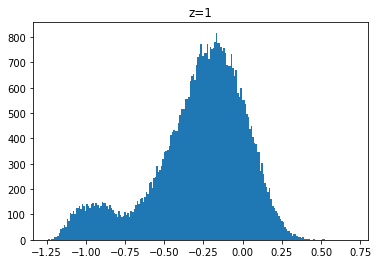

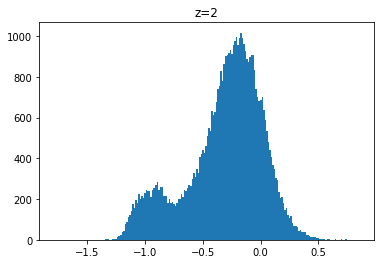

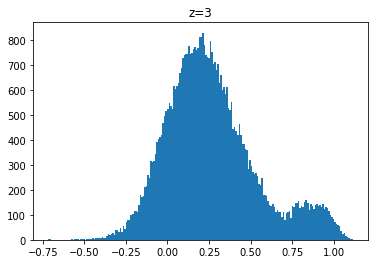

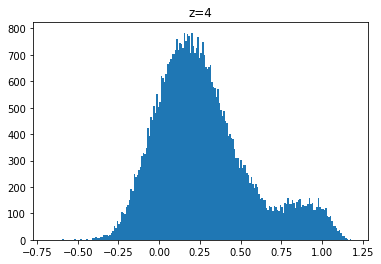

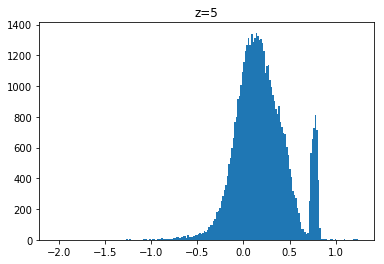

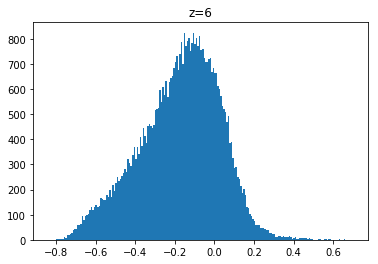

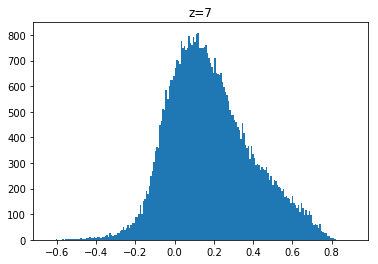

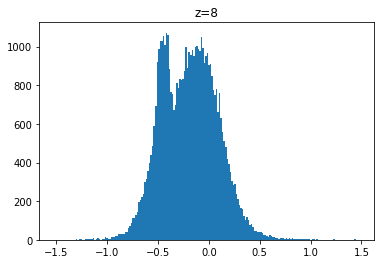

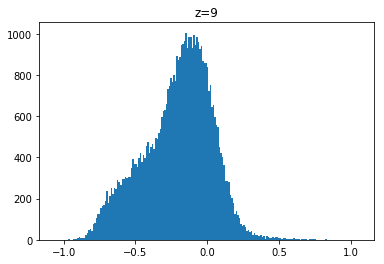

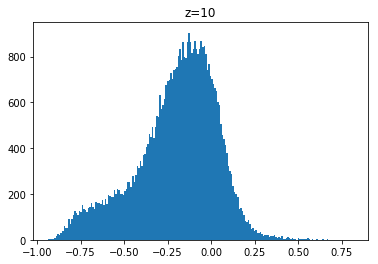

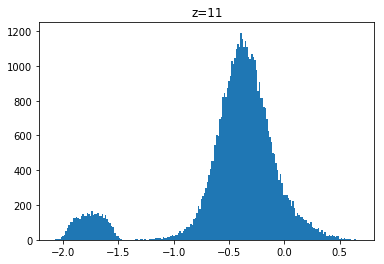

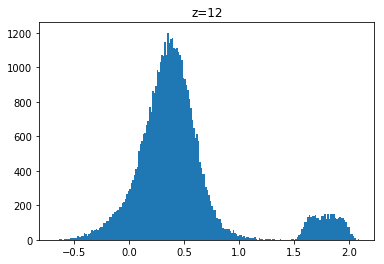

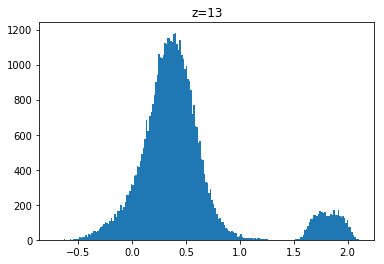

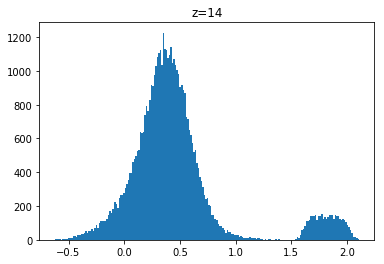

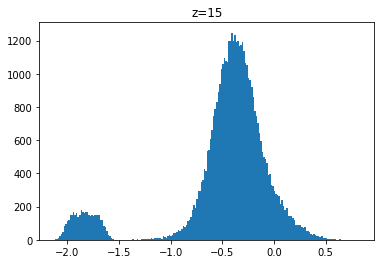

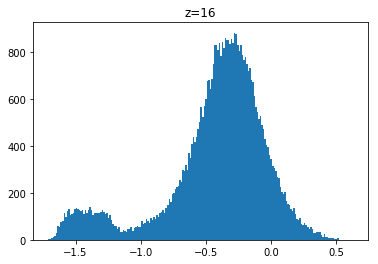

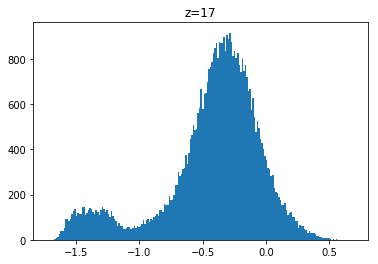

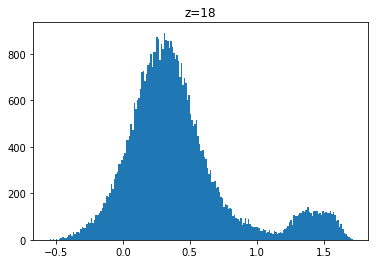

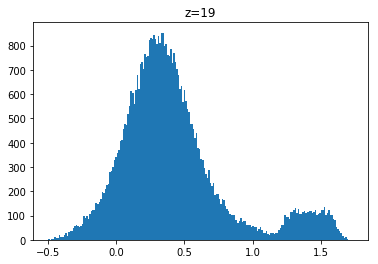

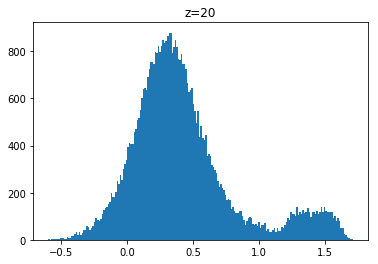

In [12]:
R = list(dec.parameters())[4].cpu()
R = np.transpose(R.data.numpy())
# sorted_R = np.sort(R, axis=-1)
# bottom_values = sorted_R[:, :10]
# top_values = sorted_R[:, -10:]
# extreme_values = np.concatenate((bottom_values, top_values), axis=1)
for i in range(20):
    plt.hist(R[i], 200)
    plt.title('z=%d' % (i+1))
    plt.show()



In [13]:
zs = []
colors = []
num_iters = NUM_ITERS()
for i in range(num_iters):
    documents = train_dataset[i * BATCH_SIZE : (i + 1) * BATCH_SIZE, :].toarray()
    documents = torch.FloatTensor(documents)
    if CUDA:
        documents = documents.cuda()
    q = enc(documents, num_samples=NUM_SAMPLES)  
    z_first = q['z_first'].dist.mean
    z_second = q['z_second'].dist.mean
    z_third = q['z_third'].dist.mean
    z_fourth = q['z_fourth'].dist.mean   
    latents = torch.cat([z_first, z_second, z_third, z_fourth], -1).cpu().squeeze(0).detach().numpy()
    zs.append(latents)
zs = np.concatenate(zs, 0)



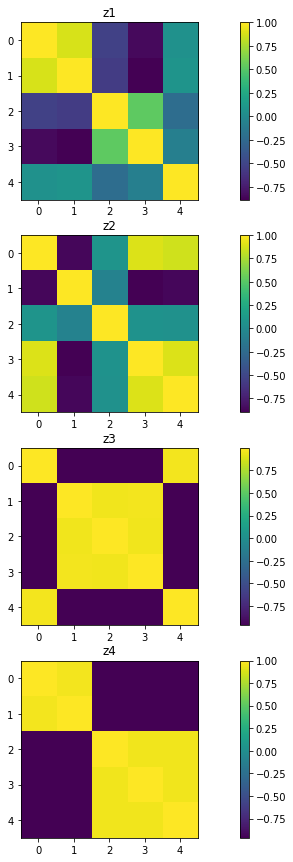

In [14]:
fig = plt.figure(figsize=(15,15))
for i in range(4):
    ax = plt.subplot(4,1,i+1)
    prior_L = list(dec.parameters())[i].cpu()
    prior_cov = make_cov(prior_L)
    plt.imshow(prior_cov.data.numpy(),interpolation='None')
    plt.title('z%d' % (i+1))
    plt.colorbar()

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
# zs2 = TSNE().fit_transform(zs)

In [96]:
import pandas as pd
df = pd.read_csv('beer_labels.csv')
beer_style = list(df['beer/style'][:NUM_DOCS])
set_labels = set(beer_style)
set_labels
df['beer/style'].value_counts()

 American IPA                           113125
 American Double / Imperial IPA          85091
 American Pale Ale (APA)                 58059
 Russian Imperial Stout                  53406
 American Double / Imperial Stout        50130
 American Porter                         46633
 American Amber / Red Ale                41721
 Belgian Strong Dark Ale                 37482
 Fruit / Vegetable Beer                  31976
 American Strong Ale                     31346
 Belgian Strong Pale Ale                 31310
 Saison / Farmhouse Ale                  30614
 Tripel                                  29958
 American Adjunct Lager                  28964
 Witbier                                 28652
 American Barleywine                     26265
 Hefeweizen                              25916
 American Brown Ale                      24125
 American Pale Wheat Ale                 22886
 English Pale Ale                        22813
 American Stout                          22597
 Märzen / Okt

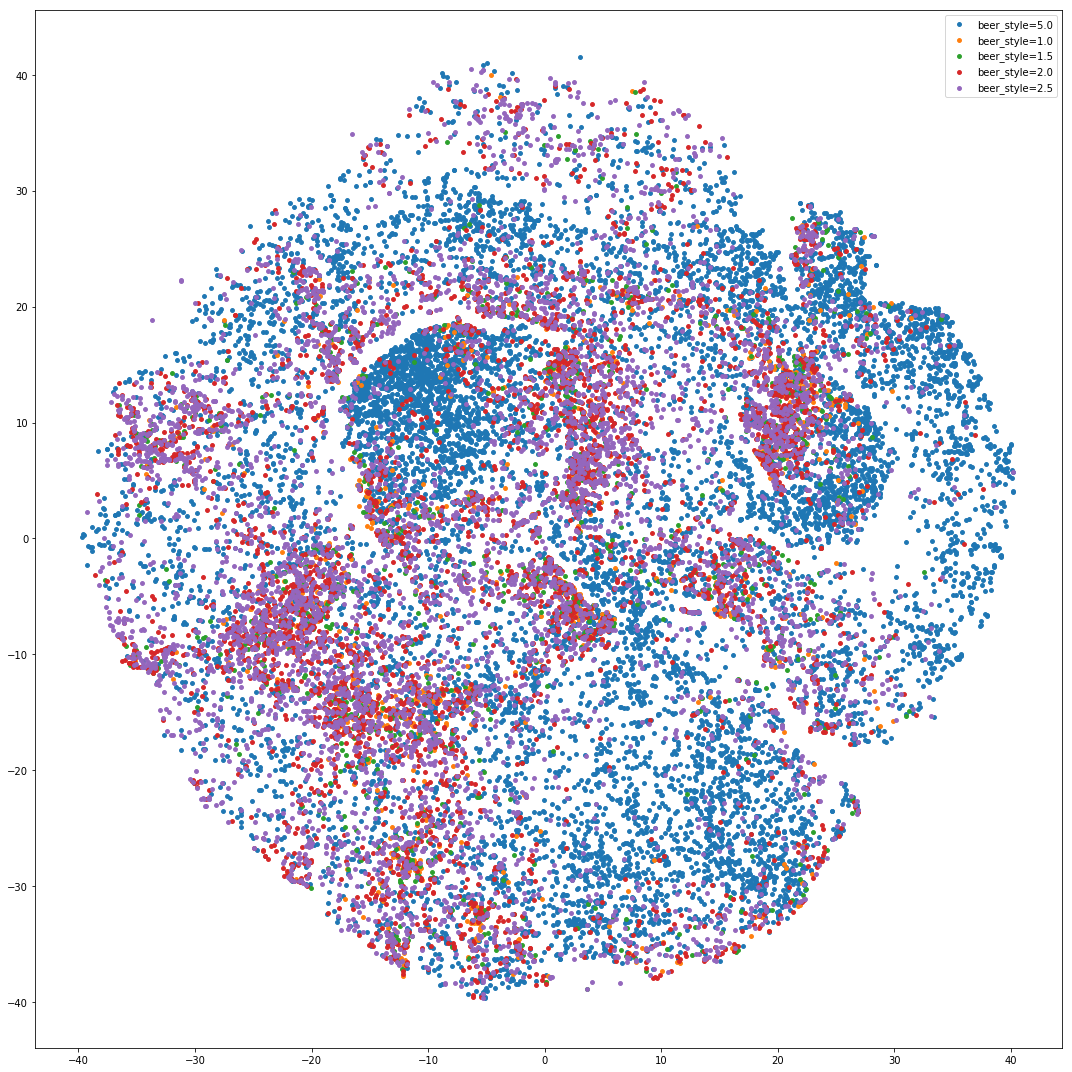

In [98]:
import pandas as pd
df = pd.read_csv('beer_labels.csv')
beer_style = list(df['review/overall'][:NUM_DOCS])
set_labels = set(beer_style)
fig = plt.figure(figsize=(15,15))
ax = plt.gca()
colors = []
        
# dark = [' English Dark Mild Ale', ' English Brown Ale', ' American Black Ale', ' American Brown Ale', ' Russian Imperial Stout', ' Irish Dry Stout']
# light = [' Hefeweizen', ' Wheatwine', ' Vienna Lager']
# filt = [dark, light] pumpkin
# filt = list(set_labels)[:15]
filt = [5.0, 1.0, 1.5, 2.0, 2.5]
for l in filt:
    index = [i for i, x in enumerate(beer_style) if x == l]
    p = ax.scatter(zs2[index, 0], zs2[index, 1], label = 'beer_style=%s' % l, cmap='viridis', s=15)
    colors.append(p.get_facecolor())
ax.legend()

fig.tight_layout()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

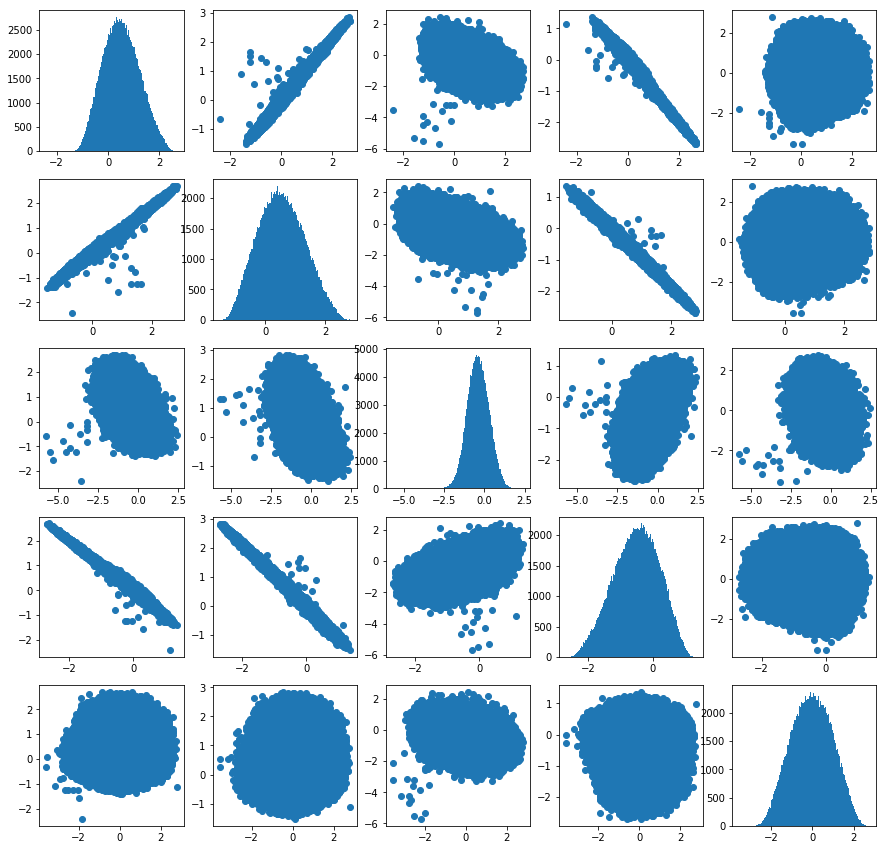

In [99]:
fig = plt.figure(figsize=(15,15))
for j in range(5):
    for k in range(5):
        ax=plt.subplot(5,5, j*5+k+1)
        if j == k:
            plt.hist(zs[:,j], 200)
        else:
            plt.scatter(zs[:,j], zs[:,k])
plt.show()

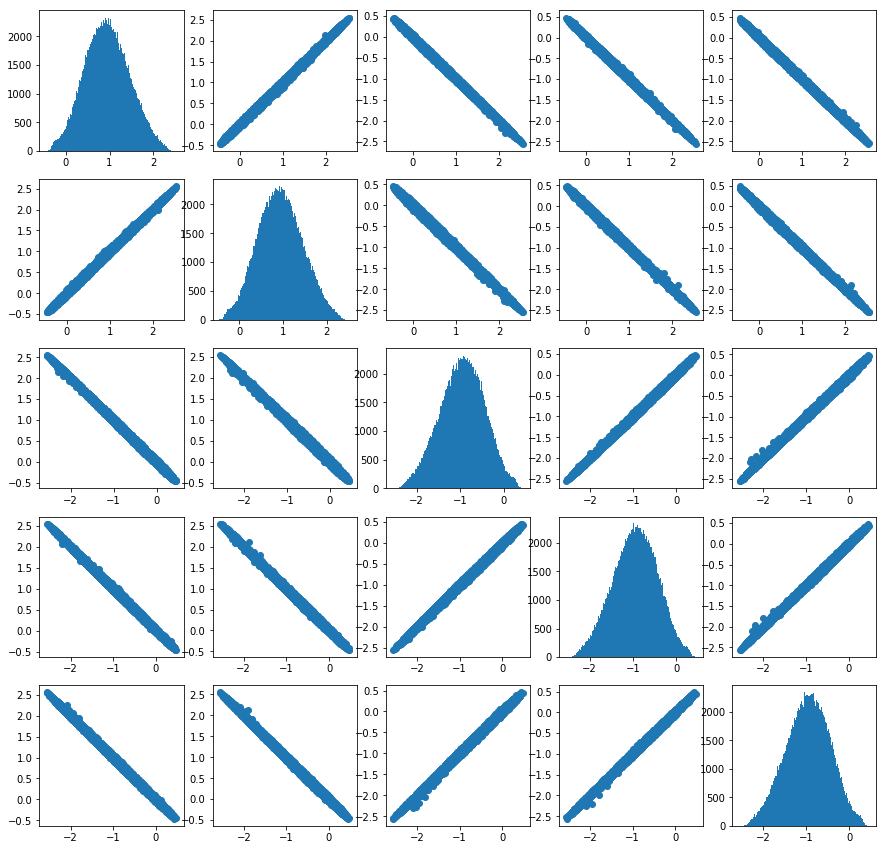

In [100]:
fig = plt.figure(figsize=(15,15))
for j in range(5):
    for k in range(5):
        ax=plt.subplot(5,5, j*5+k+1)
        if j == k:
            plt.hist(zs[:,15+j], 200)
        else:
            plt.scatter(zs[:,15+j], zs[:,15+k])
plt.show()